In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision.transforms.functional as TF

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

from PIL import Image 
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from albumentations.pytorch import ToTensorV2

<h3>A little dataset/dataloading processing??</h3>

In [3]:

from numpy import float32


class DRIVEDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms):
        self.image_dir = image_dir
        self.mask_dir = mask_dir 
        self.transforms = transforms

    def __len__(self):
        return len(self.image_dir)
        
    def __getitem__(self, index):
        image = np.array(Image.open(self.image_dir[index]))
        mask = np.array(Image.open(self.mask_dir[index]))
        mask = np.expand_dims(mask, axis=2)

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        if self.transforms is not None:
            augmentations = self.transforms(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        mask = torch.permute(mask, (2, 0, 1))

        return image, mask

In [4]:

TRAIN_IMAGE_DIR = './datasets/training/training/images/'
TRAIN_MASK_DIR = './datasets/training/training/true_mask/'

VALID_IMAGE_DIR = './datasets/training/validation/images/'
VALID_MASK_DIR = './datasets/training/validation/true_mask/'

BATCH_SIZE = 10 
IMAGE_HEIGHT = 512 
IMAGE_WIDTH = 512

training_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=30, p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std = [1.0, 1.0, 1.0],
        max_pixel_value=255
    ),
    ToTensorV2()
])

validation_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255
    ),
    ToTensorV2()
])

(584, 565, 3)
(584, 565)


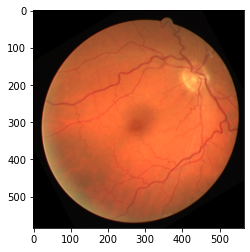

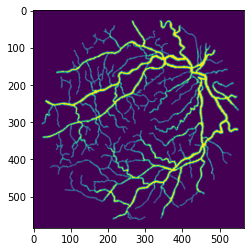

In [5]:

train_x = sorted(glob(TRAIN_IMAGE_DIR + '*'))
train_y = sorted(glob(TRAIN_MASK_DIR + '*'))


valid_x = sorted(glob(VALID_IMAGE_DIR + '*'))
valid_y = sorted(glob(VALID_MASK_DIR + '*'))

img = Image.open(valid_x[1])
img2 = Image.open(valid_y[1])
print(np.array(img).shape)
print(np.array(img2).shape)
plt.imshow(img)
plt.figure()
plt.imshow(img2)

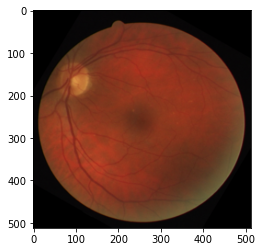

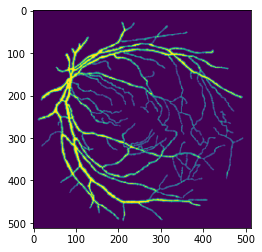

In [6]:
train_dataset = DRIVEDataset(train_x, train_y, transforms=training_transform)
valid_dataset = DRIVEDataset(valid_x, valid_y, transforms=validation_transform)

item = train_dataset.__getitem__(10)
plt.imshow(torch.permute(item[0], (1, 2, 0)))
plt.figure()
plt.imshow(torch.permute(item[1], (1, 2, 0)))

In [7]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(trainloader))
print(len(validloader))

10
2


<h3>A little trolling with double conv??</h3>

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

<h3>A little trolling with network definition?</h3>

<h1>OUTSIDE TESTING????</h1>

In [9]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [10]:

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # process Down-UNET:
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        #process Up-UNET:
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2 
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        self.bottom = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels=out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottom(x)
        skip_connections = skip_connections[::-1]
        
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_res = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_res)
        
        x = self.final_conv(x)
        return x

<h3>A little pre-network testing??</h3>

In [11]:
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    predictions = model(x)
    
    print(x.shape)
    print(predictions.shape)
    assert predictions.shape == x.shape
    
test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


<h2> Let's do some TRAINING????</h2>

In [12]:
EPOCHS = 2
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPT_PATH = './checkpoints/checkpoint.pth'
print(f"Using: {DEVICE}")

model = build_unet().to(DEVICE)
model

Using: cuda


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [13]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [14]:
for epoch in range(EPOCHS):

    model.train()     
    for batch, (image, mask) in enumerate(trainloader):
        image, mask = image.to(DEVICE), mask.to(DEVICE)
        
        output = model(image)
        loss = criterion(output, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"On epoch: {epoch}")

RuntimeError: CUDA out of memory. Tried to allocate 320.00 MiB (GPU 0; 4.00 GiB total capacity; 3.13 GiB already allocated; 0 bytes free; 3.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF